In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\picca\anaconda3\envs\tensor2_GAN_picca\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


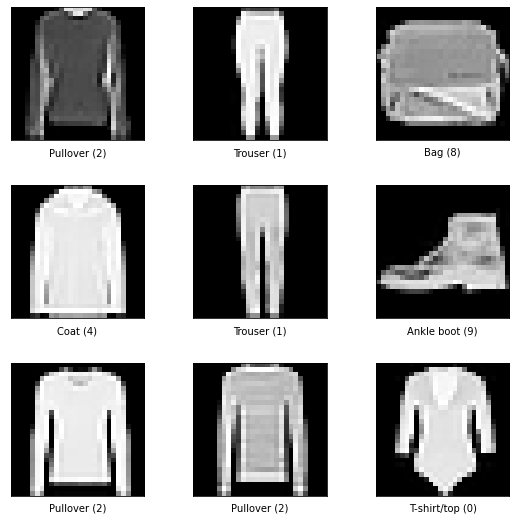

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split= 'train', shuffle_files=True, with_info=True)
fig= tfds.show_examples(ds_train, ds_info)
batch_size = 64
image_shape = (32, 32, 1)

In [3]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2]) # [:2] h*W [:3] h*W*v
    image = tf.cast(image, tf.float32)
    image = (image-127.5) / 127.5
    return image

In [4]:
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

In [5]:
# print(ds_info)
# print(ds_info.splits['train'])
train_num = ds_info.splits['train'].num_examples

In [6]:
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

938


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_20 (Batc (None, 8192)              32768     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 8, 256)         10

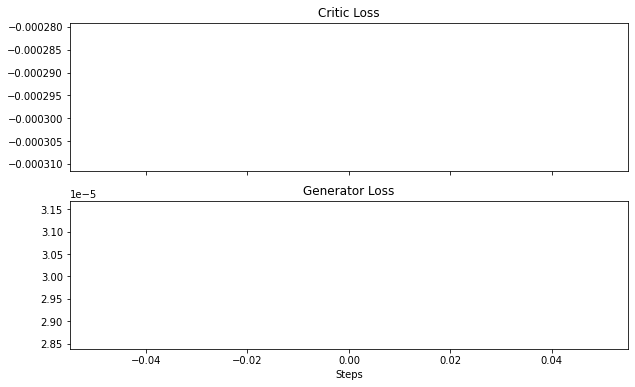

Step 100: g_loss -42.0608 , critic_loss -16.6791, critic_fake -14.0745, critic_real -2.6046


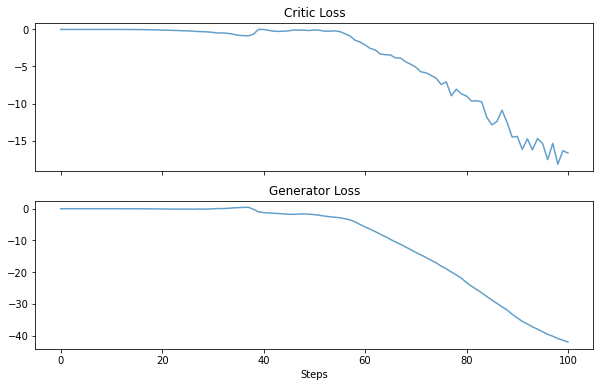

Step 200: g_loss -63.0890 , critic_loss -42.2490, critic_fake -7.4300, critic_real -34.8190


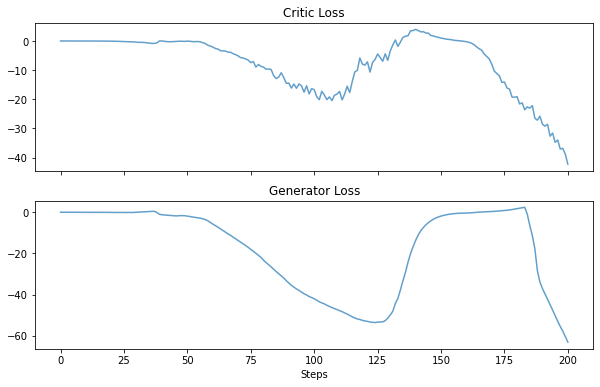

Step 300: g_loss -10.2610 , critic_loss 1.8947, critic_fake 6.2030, critic_real -4.3083


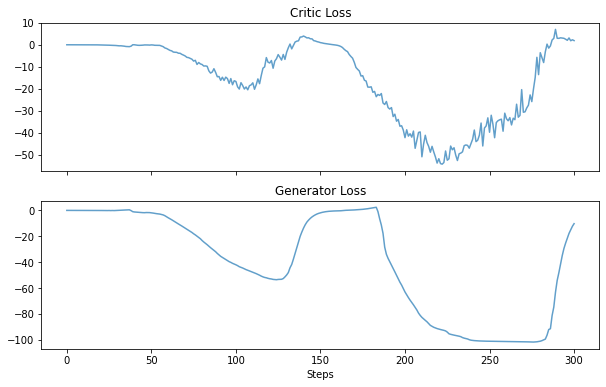

Step 400: g_loss 0.0477 , critic_loss -1.4193, critic_fake 0.0879, critic_real -1.5072


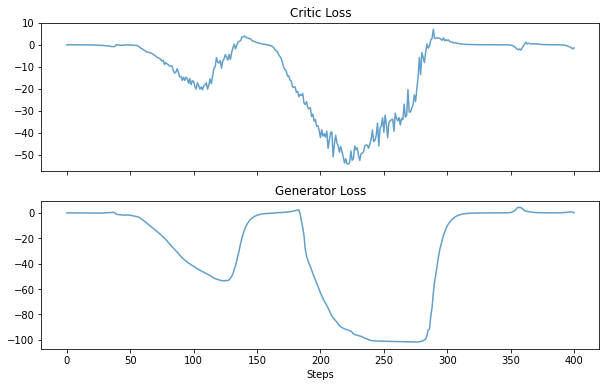

Step 500: g_loss -0.0031 , critic_loss -0.0365, critic_fake -0.0646, critic_real 0.0281


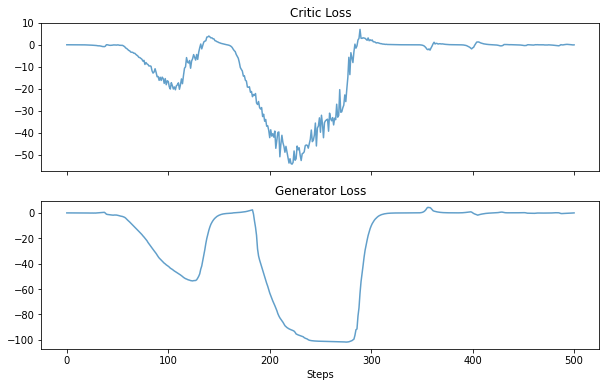

Step 600: g_loss -0.3223 , critic_loss -0.0191, critic_fake 0.1972, critic_real -0.2163


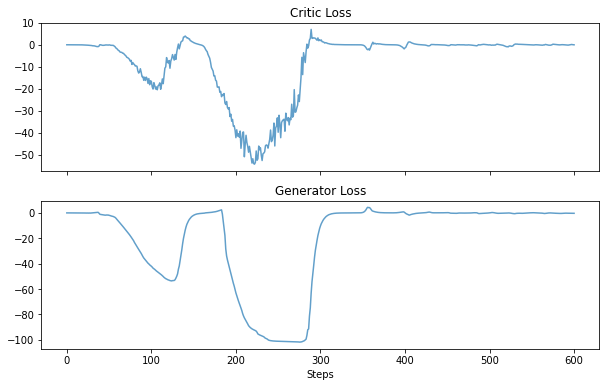

Step 700: g_loss -0.4190 , critic_loss 0.0910, critic_fake 0.4431, critic_real -0.3521


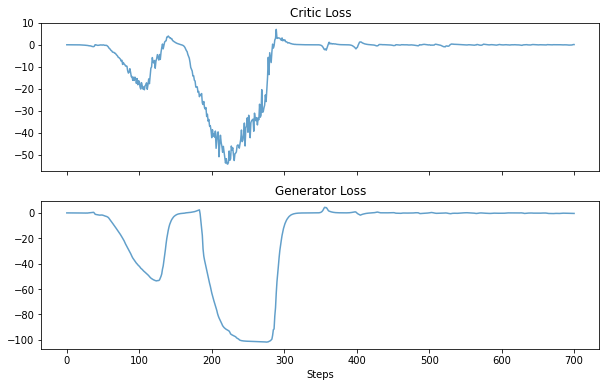

Step 800: g_loss -0.2331 , critic_loss 0.1020, critic_fake 0.2454, critic_real -0.1433


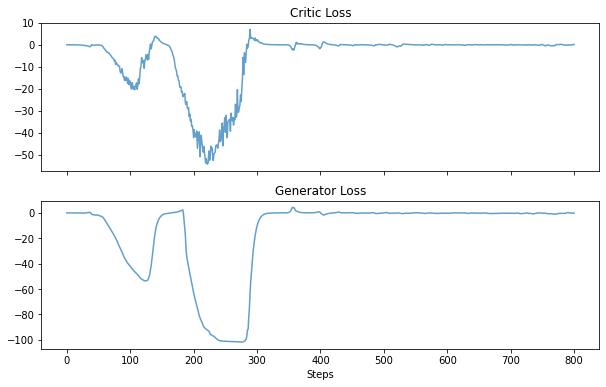

Step 900: g_loss 0.0790 , critic_loss -0.3491, critic_fake -0.0876, critic_real -0.2614


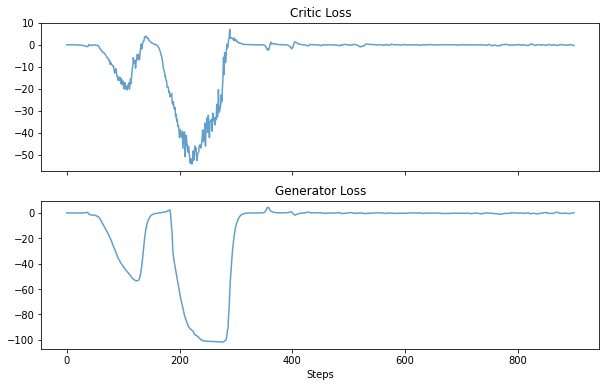

Step 1000: g_loss -0.7418 , critic_loss 0.0373, critic_fake 0.6520, critic_real -0.6147


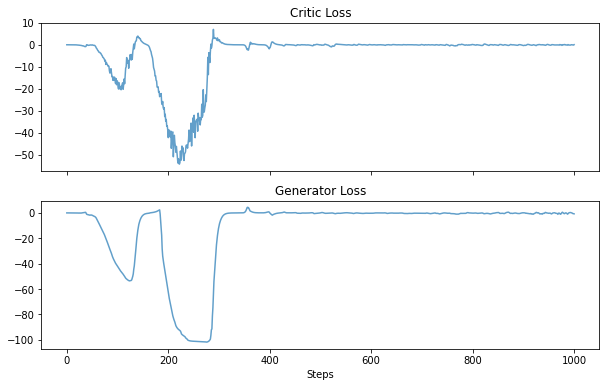

Step 1100: g_loss -1.1790 , critic_loss -0.0690, critic_fake 1.1450, critic_real -1.2140


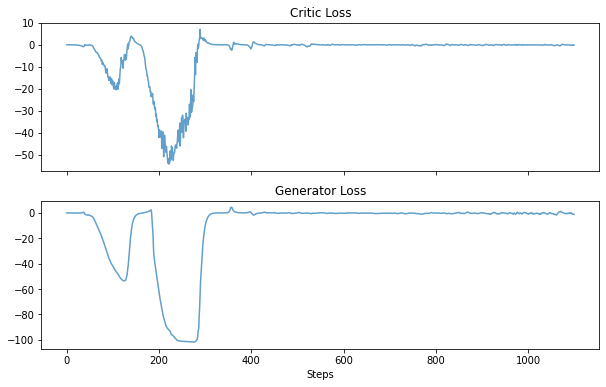

Step 1200: g_loss -0.9194 , critic_loss -0.1088, critic_fake 0.6722, critic_real -0.7810


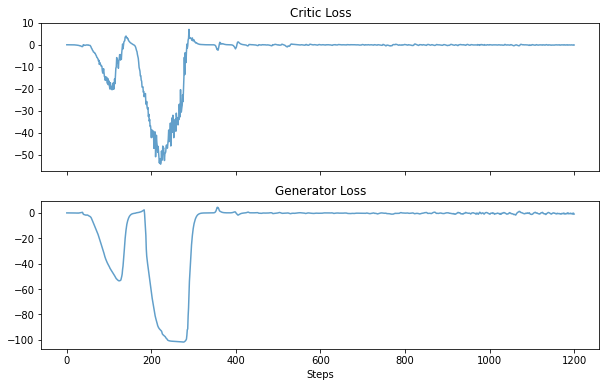

Step 1300: g_loss -0.0165 , critic_loss -0.0104, critic_fake 0.1955, critic_real -0.2059


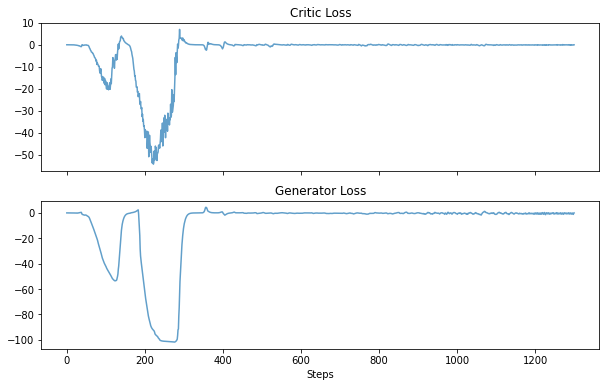

Step 1400: g_loss -0.7498 , critic_loss -0.0082, critic_fake 0.8939, critic_real -0.9021


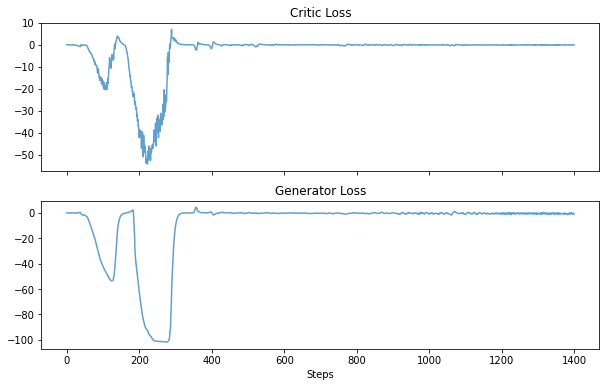

Step 1500: g_loss -0.3658 , critic_loss -0.0610, critic_fake 0.4475, critic_real -0.5085


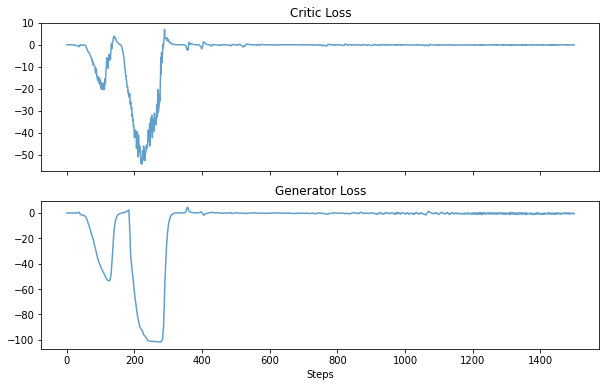

Step 1600: g_loss -0.5356 , critic_loss -0.0773, critic_fake 0.7137, critic_real -0.7911


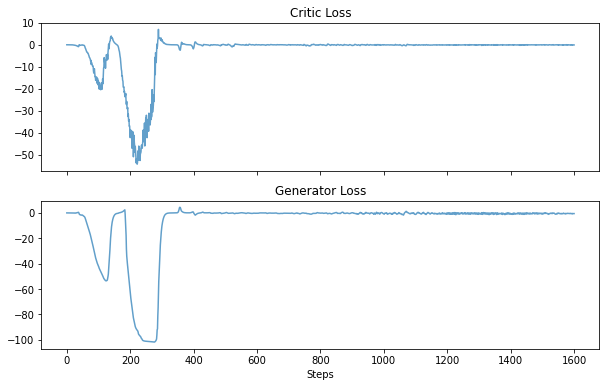

Step 1700: g_loss -0.6457 , critic_loss -0.0027, critic_fake 0.6085, critic_real -0.6111


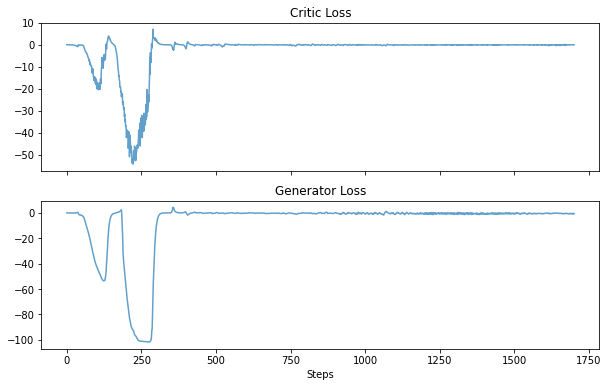

Step 1800: g_loss -0.0781 , critic_loss -0.0702, critic_fake 0.2124, critic_real -0.2826


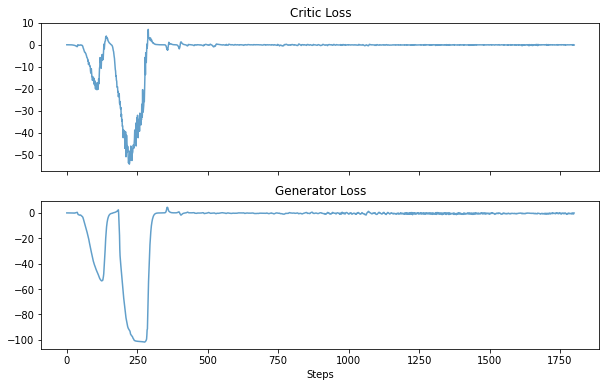

Step 1900: g_loss -0.3909 , critic_loss 0.0334, critic_fake 0.4472, critic_real -0.4138


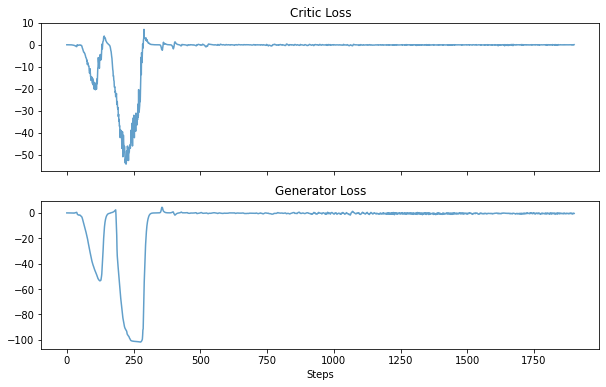

In [11]:
""" 
WGAN 
"""
class WGAN():
    def __init__(self, input_shape):
        self.z_dim = 128
        self.input_shape = input_shape

        # losses
        self.loss_critic_real = {}
        self.loss_critic_fake = {}
        self.loss_critic = {}
        self.loss_generator = {}

        # critic
        self.n_critic = 5
        self.critic = self.build_critic()
        self.critic.trainable = False
        self.optimizer_critic =  RMSprop(5e-5)

        # build generator pipeline  with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss=self.wasserstein_loss, optimizer=RMSprop(5e-5))
        self.critic.trainable = True

    def wasserstein_loss(self, y_true, y_pred):
        w_loss = -tf.reduce_mean(y_true*y_pred)
        return w_loss

    # # generator model
    # def build_generator(self):
    #     DIM = 128
    #     model = tf.keras.Sequential(name='Generator')

    #     model.add(layers.Input(shape=[self.z_dim]))

    #     model.add(layers.Dense(4*4*4*DIM))
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.ReLU())
    #     model.add(layers.Reshape(4, 4, 4*DIM))

    #     model.add(layers.UpSampling2D((2,2), interpolation="bilinerar"))
    #     model.add(layers.Conv2D(2*DIM, 5, padding='same'))
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.ReLU())

    #     model.add(layers.UpSampling2D((2,2), interpolation="bilinerar"))
    #     model.add(layers.Conv2D(DIM, 5, padding='same'))
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.ReLU())

    #     model.add(layers.UpSampling2D((2, 2), interpolation="bilinerar"))
    #     model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
    #     return model
    def build_generator(self):
    
        DIM = 128
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,4*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model

    # critic model/descriminator model
    def build_critic(self):
        DIM = 128
        model = tf.keras.Sequential(name= 'critics')
        
        model.add(layers.Input(shape=self.input_shape))

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same'))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    # train critic model
    def train_critic(self, real_images, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)

        with tf.GradientTape() as total_tape:

            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)

            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)

            total_loss = loss_fake + loss_real

            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)

            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))
        
        for layer in self.critic.layers:
            weights = layer.get_weights()
            weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
            layer.set_weights(weights)
        
        return loss_fake, loss_real

    # train generator
    def train(self, data_generator, batch_size, steps, interval = 200):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range (self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real

            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)

            self.loss_critic_real[i] = loss_real.numpy()
            self.loss_critic_fake[i] = loss_fake.numpy()
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss

            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} , critic_loss {:.4f}, critic_fake {:.4f}, critic_real {:.4f}"\
                    .format(i, g_loss, critic_loss, loss_fake, loss_real)
                print(msg)

                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()


    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_row * 2.5, grid_col*2.5))

        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1] == 1:
                    axarr[col].imshow(images[col,:,:,0]*0.5 + 0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5 + 0.5)
                axarr[col].axis('off')
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic Loss', alpha=0.7)
        ax1.set_title('Critic Loss')
        ax2.plot(list(self.loss_generator.values()), label='Generator Loss', alpha=0.7)
        ax2.set_title('Generator Loss')

        plt.xlabel('Steps')
        plt.show()


wgan = WGAN(image_shape)

wgan.generator.summary()

wgan.critic.summary()

wgan.train(iter(ds_train), batch_size, 2000, 100)
# wgan.train(iter(ds_train), batch_size, 200, 100)

z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

wgan.generator.save_weights('./wgan_models_practice/wgan_fashion_mnist_2/wgan_fashion_mnist_1.weights')
        

